# Similarity of plans

In this notebook, I will ask users to select plan benefits that are most important to them and create a vector based on those selections. This vector object is the primary mechanism of comparison for plans. These vectors can just be thought of as geometrical vectors, and so should have an angle between them. This angle is precisely the quantity which the similarity score we will use, cosine similarity, implicitly measures. Two vectors have a higher similarity score when the angle between them is smaller.

I will compare this user-generated vector with the unique plan vectors available in our `no_dupes` dataframe to analyze their similarity. When we talk about whether or not two plans are similar, we're really talking about the similarity of the vectors. 

I use numpy to perform efficient numerical matrix operations and some sorting. I use the tkinter library to obtain user input via a GUI.

# Outcome

This recommender system could be useful to a benefits broker as a proprietary tool used to help clients select a health plan that is best suited to their companies.

This recommender system could also be used by an HR manager at a company to self-select plans based on the features selected in the health plan.

The recommender systems alleviates certain difficulties in selecting plans based on features. Most websites allow users to compare plans on price only. However, the features that are included or excluded from low price plans, as compared to high price plans, may be unclear.

In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics.pairwise import cosine_similarity

import pickle
from tabulate import tabulate

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
with open ('../pickles/df.pkl', 'rb') as pkl:
    df = pickle.load(pkl)

In [5]:
with open ('../pickles/ben_cols_dum.pkl', 'rb') as pkl:
    ben_cols_dum = pickle.load(pkl)

In [14]:
test = df.drop(columns=ben_cols_dum)

In [16]:
test[test.select_dtypes(['object']).columns] = test.select_dtypes(['object']).apply(lambda x: x.astype('category'))

In [17]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3977375 entries, 0 to 3977374
Data columns (total 26 columns):
BusinessYear                                 int64
StateCode                                    category
RateEffectiveDate                            category
RateExpirationDate                           category
PlanId                                       category
RatingAreaId                                 category
Tobacco                                      category
Age                                          category
IndividualRate                               float64
IndividualTobaccoRate                        float64
Couple                                       float64
PrimarySubscriberAndOneDependent             float64
PrimarySubscriberAndTwoDependents            float64
PrimarySubscriberAndThreeOrMoreDependents    float64
CoupleAndOneDependent                        float64
CoupleAndTwoDependents                       float64
CoupleAndThreeOrMoreDependents    

In [3]:
with open ('../pickles/rate_cols.pkl', 'rb') as pkl:
    rate_cols = pickle.load(pkl)
    excl = ['BusinessYear', 'RateEffectiveDate', 'RateExpirationDate', 'RowNumber']
    rate_cols = [col for col in rate_cols if col not in excl]

In [4]:
exclude = ['BusinessYear',
'StateCode',
'RateEffectiveDate',
'RateExpirationDate',
'PlanId',
'RatingAreaId',
'Tobacco',
'Age',
'IndividualRate',
'IndividualTobaccoRate',
'Couple',
'PrimarySubscriberAndOneDependent',
'PrimarySubscriberAndTwoDependents',
'PrimarySubscriberAndThreeOrMoreDependents',
'CoupleAndOneDependent',
'CoupleAndTwoDependents',
'CoupleAndThreeOrMoreDependents',
'RowNumber',
'IsNoticeRequiredForPregnancy',
'IsReferralRequiredForSpecialist',
'ChildOnlyOffering',
'WellnessProgramOffered',
'DiseaseManagementProgramsOffered',
'OutOfCountryCoverage',
'NationalNetwork',
'ben_key']

## Filter the data

Below, users can filter by a couple of parameters, as follows:

- `'Age'`
- `'Tobacco User'`
- `'State'`

Other filters the user can select for include:

- `'IsNoticeRequiredForPregnancy'`: Yes / No / No Preference
- `'IsReferralRequiredForSpecialist'`: Yes / No / No Preference
- `'ChildOnlyOffering'`: Allows Child-Only, Allows Adult and Child-Only
- `'WellnessProgramOffered'`: Yes / No / No Preference
- `'OutOfCountryCoverage'`: Yes / No
- `'NationalNetwork'`: Yes / No

In [5]:
def filter_plans(age, tobacco, state):

    """
    Certain states with their own
    exchanges, such as CA and NY,
    are missing from this filter.
    """

    if tobacco == 'yes':
        filtered_df = df[(df['Age'] == age) &
                         (df['IndividualTobaccoRate'].notnull()) &
                         (df['StateCode'] == state)]
    elif tobacco == 'no_pref':
        filtered_df = df[(df['Age'] == age) &
                         (df['StateCode'] == state)]
    return filtered_df

Below are the additional criteria on which users can filter, with all available choices.

In [6]:
other_feats = {
'IsNoticeRequiredForPregnancy': [None, 'Yes', 'No'],
'IsReferralRequiredForSpecialist': [None, 'Yes', 'No'],
'ChildOnlyOffering': ['Allows Child-Only', 'Allows Adult and Child-Only'],
'WellnessProgramOffered': [None, 'Yes', 'No'],
'OutOfCountryCoverage': ['Yes', 'No'],
'NationalNetwork': ['No', 'Yes', 'YEs']
}

In [7]:
other_feats_key = list(other_feats.keys())

In [8]:
def addl_filter(feats = other_feats):
    filtered_df = filter_plans('30', 'yes', 'AZ')
    for feat in feats:
        filtered_df = filtered_df[filtered_df[feat].isin(feats[feat])]
    return filtered_df

Below, users can customize to include only those choices they are interested in, and then run the `addl_filter` function and pass `my_feats` as a parameter.

In [9]:
my_feats = {
'IsNoticeRequiredForPregnancy': [None, 'Yes', 'No'],
'IsReferralRequiredForSpecialist': [None, 'Yes', 'No'],
'ChildOnlyOffering': ['Allows Child-Only', 'Allows Adult and Child-Only'],
'WellnessProgramOffered': [None, 'Yes', 'No'],
'OutOfCountryCoverage': ['Yes', 'No'],
'NationalNetwork': ['No', 'Yes', 'YEs']
}

In [10]:
df_filt = addl_filter(my_feats)

Below, I'm creating a list of benefits that are available for selection based on the `df_filt` from above. This list will be passed into the `tkinter` GUI which will allow users to select from benefits that are actually, verifiably available from the plans they filtered for.

In [11]:
ben_cols_dum = [col for col in df_filt.columns if col not in exclude]

In [12]:
ben_cols_dum = [col for col in ben_cols_dum if df_filt[col].sum() != 0]

## Filtering by unique plan vectors: `no_dupes`

In a previous notebook, I created a matrix of vectors (called `no_dupes`) in which each vector represented a unique combination of available benefits. No two vectors are the same (however, a particular vector can represent many different types of plans).

Below, I will condense the `no_dupes` matrix to only those plans available based on the filtering performed above.

As you will see, we start off with 215 rows in `no_dupes` (representing 215 unique plan vectors), but after filtering, we are left with far fewer unique plans (the specific amount that remain depends on the filtering criteria from above).

In [13]:
with open ('../pickles/no_dupes.pkl', 'rb') as pkl:
    no_dupes = pickle.load(pkl)

In [14]:
no_dupes.shape

(215, 207)

In [15]:
unique_keys = list(df_filt['ben_key'].unique())

In [16]:
unique_keys

[214, 68, 8, 86, 6, 156, 7, 157]

In [17]:
no_dupes = no_dupes[no_dupes.index.isin(unique_keys)]

In [18]:
no_dupes.shape

(8, 207)

Below, I am storing the column names and indexes of the filtered dataframe `df_filt` and converting it into a NumPy array for efficient computation. I will use the dictionaries later as a lookup into the NumPy array.

In [19]:
col_dict = dict(zip(no_dupes.columns, range(len(no_dupes.columns))))

In [20]:
ind_dict = dict(zip(range(len(no_dupes)), no_dupes.index))

In [21]:
no_dupes_mat = np.asarray(no_dupes)

## Generate a unique plan

Using tkinter, Python's inbuilt GUI, I ask users to select the features they would like in their plan, and create a vector based on those selected features. Any benefits that are not selected are treated homogeneously and equal to all other un-selected features, so no information is "lost".

In [22]:
from tkinter import *
import tkinter as tk

# ----- Section: functions -----

sel_feats = []

def on_keyrelease(event):

    # get text from entry
    value = event.widget.get()
    value = value.strip().lower()

    # get data from test_list
    if value == '':
        data = test_list
    else:
        data = []
        for item in test_list:
            if value in item.lower():
                data.append(item)                

    # update data in listbox
    listbox_update(data)


def listbox_update(data):
    # delete previous data
    l1.delete(0, 'end')

    # sorting data 
    data = sorted(data, key=str.lower)

    # put new data
    for item in data:
        l1.insert('end', item)

def onselect(event):
    selection = l1.curselection()
    for i in selection:
        entry = l1.get(i)
        l2.insert(END, entry)
        print(l1.get(i))
        
def submit(event):
    content = l2.get(0, tk.END)
    for i in content:
        sel_feats.append(i)
    print(sel_feats)

# ----- Section: code -----

test_list = ben_cols_dum

root = Tk()

label = Label(root, text="Type below!")
label.pack(side=TOP)

entry = Entry(root,
             width=40)
entry.pack(side=TOP)
entry.bind('<KeyRelease>', on_keyrelease)

l1 = Listbox(root, 
             selectmode=MULTIPLE, 
             width=40, 
             height=10)
l1.pack(padx=20, pady=20)
listbox_update(test_list)

btn = Button(root, text="Add")
btn.pack()
btn.bind('<Button-1>', onselect)

l2 = Listbox(root, width=40, height=10)
l2.pack(padx=20, pady=20)

btn = Button(root, text="Submit")
btn.pack()
btn.bind('<Button-1>', submit)

root.mainloop()

Autism Spectrum Disorders
Chiropractic Care
Cosmetic Surgery
Delivery and All Inpatient Services for Maternity Care
['Autism Spectrum Disorders', 'Chiropractic Care', 'Cosmetic Surgery', 'Delivery and All Inpatient Services for Maternity Care']
['Autism Spectrum Disorders', 'Chiropractic Care', 'Cosmetic Surgery', 'Delivery and All Inpatient Services for Maternity Care', 'Autism Spectrum Disorders', 'Chiropractic Care', 'Cosmetic Surgery', 'Delivery and All Inpatient Services for Maternity Care']


In [23]:
sel_feats = list(set(sel_feats))

In [24]:
ben_vec = np.zeros(no_dupes_mat.shape[1])

Below, I fill in "1s" in my NumPy matrix corresponding to the features selected by the user.

In [25]:
sel_feats

['Chiropractic Care',
 'Autism Spectrum Disorders',
 'Cosmetic Surgery',
 'Delivery and All Inpatient Services for Maternity Care']

In [26]:
for benefit in sel_feats:
    ben_vec[col_dict[benefit]] = 1

In [27]:
ben_vec = np.reshape(ben_vec, (1, -1))

In [28]:
ben_vec.shape

(1, 207)

## Find cosine similarity between `ben_vec` and `no_dupes`

In [29]:
cos_mat = cosine_similarity(ben_vec, no_dupes_mat)

In [30]:
i = 0
top_matches = []
for item in cos_mat[0]:
    if item == 0:
        pass
    else:
        top_matches.append([item, ind_dict[i]])
    i += 1
top_matches.sort(reverse=True)

Below are the plans that best match the user's selected criteria.

In [31]:
print("Ben_keys most similar to ben_vec:", [b for a, b in top_matches])

Ben_keys most similar to ben_vec: [214, 7, 8, 86, 157, 156, 6, 68]


## View plan details

Below, the user can run a couple of functions to view additional details about his select plan and plan variants.

In [32]:
print("\n", "Using the list below, please find the Index # of the plan variant you would like to view.")
print(tabulate(
    [[top_matches[i][1], top_matches[i][0], i] for i in range(len(top_matches))], 
    ["Plan Variant", "Similarity", "Index #"], 
    tablefmt="grid"
))



 Using the list below, please find the Index # of the plan variant you would like to view.
+----------------+--------------+-----------+
|   Plan Variant |   Similarity |   Index # |
+================+==============+===========+
|            214 |     0.235702 |         0 |
+----------------+--------------+-----------+
|              7 |     0.200446 |         1 |
+----------------+--------------+-----------+
|              8 |     0.19696  |         2 |
+----------------+--------------+-----------+
|             86 |     0.1905   |         3 |
+----------------+--------------+-----------+
|            157 |     0.181902 |         4 |
+----------------+--------------+-----------+
|            156 |     0.181902 |         5 |
+----------------+--------------+-----------+
|              6 |     0.138675 |         6 |
+----------------+--------------+-----------+
|             68 |     0.13484  |         7 |
+----------------+--------------+-----------+


Below, please enter your selected Index # in the `covered_feats` function, which will allow you to see the features that are covered in the plan variant:

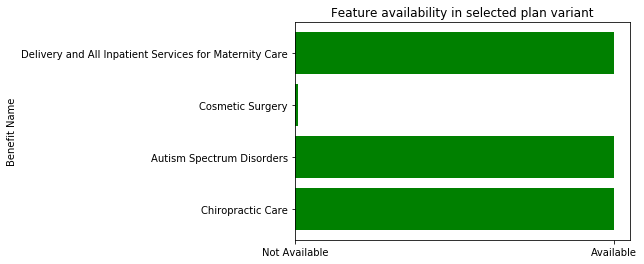

In [33]:
def covered_feats(index):
    # Get covered features in dataframe
    feat_coverage = df_filt[df_filt['ben_key'] == top_matches[index][1]][sel_feats].head(10)

    # Plot the features
    x = list(feat_coverage.columns)
    coverage = [1 if feat_coverage[i].sum() > 0 else 0.01 for i in list(feat_coverage.columns)]
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'g']

    x_pos = [i for i, _ in enumerate(x)]

    plt.barh(x_pos, coverage, color='green')
    plt.ylabel("Benefit Name")
    plt.title("Feature availability in selected plan variant")

    plt.yticks(x_pos, x)
    plt.xticks(np.arange(2), ('Not Available', 'Available'))

    plt.show()
    return feat_coverage
feat_coverage = covered_feats(3)

Below, please enter the index number in the `matching_plans` function corresponding to the plan variant you would like to view. This function will then show you all the available plans in that plan variant.

In [34]:
def matching_plans(index):
    matches = df_filt[df_filt['ben_key'] == top_matches[index][1]][rate_cols].dropna(axis=1)
    print("\n", "There are", matches.shape[0], "plans available for selection:")
    return matches
matches = matching_plans(3).sort_values('IndividualRate')
matches.tail()


 There are 6 plans available for selection:


,StateCode,PlanId,RatingAreaId,Tobacco,Age,IndividualRate,IndividualTobaccoRate
114110,AZ,65441AZ0080002,Rating Area 4,Tobacco User/Non-Tobacco User,30,196.95,206.79
114156,AZ,65441AZ0060002,Rating Area 4,Tobacco User/Non-Tobacco User,30,203.57,213.74
114340,AZ,65441AZ0100001,Rating Area 4,Tobacco User/Non-Tobacco User,30,233.21,244.87
114386,AZ,65441AZ0080001,Rating Area 4,Tobacco User/Non-Tobacco User,30,236.53,248.36
114432,AZ,65441AZ0060001,Rating Area 4,Tobacco User/Non-Tobacco User,30,245.03,257.28


The below shows the user the price by `'RatingAreaId'` - with some areas in the state more expensive than others.

In [35]:
matches.groupby('RatingAreaId').mean().dropna().sort_values('IndividualRate')

,IndividualRate,IndividualTobaccoRate
RatingAreaId,,
Rating Area 4,218.118333,229.021667


In [36]:
## Figure out cost of plans like mine in other states

In [37]:
with open ('../pickles/attributes.pkl', 'rb') as pkl:
    attributes = pickle.load(pkl)

In [38]:
attr_exclude = [
    'AVCalculatorOutputNumber',
    'BusinessYear',
    'CompositeRatingOffered',
    'EHBPercentTotalPremium',
    'FormularyId',
    'HIOSProductId',
    'HPID',
    'ImportDate',
    'IndianPlanVariationEstimatedAdvancedPaymentAmountPerEnrollee',
    'IssuerId',
    'IssuerId2',
    'NetworkId',
    'SourceName',
    'QHPNonQHPTypeId',
    'PlanEffictiveDate',
    'PlanExpirationDate',
    'RowNumber',
    'ServiceAreaId',
    'TIN',
    'VersionNum',
    'StateCode2'
]
attribute_cols = [col for col in list(attributes.columns) if col not in attr_exclude]

In [45]:
def view_details(plan, view_cols=other_feats_key):
    details = attributes[attributes['PlanId'] == plan][view_cols].T.dropna()
    return details
view_details('70239AZ0010054')

,50747
IsNoticeRequiredForPregnancy,No
IsReferralRequiredForSpecialist,Yes
ChildOnlyOffering,Allows Adult and Child-Only
WellnessProgramOffered,No
OutOfCountryCoverage,Yes
NationalNetwork,No


In [43]:
compare = view_details(matches['PlanId'].iloc[0], other_feats_key)
for plan in matches['PlanId']:
    interim = pd.merge(compare, 
             view_details(plan, other_feats_key),
             left_index=True,
             right_index=True)
    compare = interim
compare

,50670_x,50670_y,50663,50656,50652,50648,50644
IsNoticeRequiredForPregnancy,Yes,Yes,Yes,Yes,Yes,Yes,Yes
IsReferralRequiredForSpecialist,No,No,No,No,No,No,No
ChildOnlyOffering,Allows Adult and Child-Only,Allows Adult and Child-Only,Allows Adult and Child-Only,Allows Adult and Child-Only,Allows Adult and Child-Only,Allows Adult and Child-Only,Allows Adult and Child-Only
WellnessProgramOffered,No,No,No,No,No,No,No
OutOfCountryCoverage,Yes,Yes,Yes,Yes,Yes,Yes,Yes
NationalNetwork,No,No,No,No,No,No,No
